In [136]:
# load necessary libraries
%matplotlib inline
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','flight_delay'))
import numpy as np
import pandas as pd
import plotly as ply
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as pp
import statsmodels.formula.api as smf
from utils import df_par # for parallelization

In [2]:
data_dir = os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','data','flight_data')
misc_data_dir = os.path.join(os.path.abspath(os.path.join('..')),'data-wrangling','data','misc')
# Before importing data, let's define datatypes of columns
types = {0: 'int8', 1: 'category', 2: 'category', 3: 'int16', 4: 'int16', 5: 'int32',
         6: 'int16', 7: 'int32', 18: 'bool', 19: 'int8', 20: 'bool', 24: 'int16',
         25: 'int16', 26: 'int16', 27: 'int16', 28: 'int16', 29: 'int16', 31: 'float32',
         32: 'float32', 33: 'float32', 34: 'float32', 35: 'float32', 36: 'float32', 
         37: 'float32', 38: 'float32', 39: 'float32', 40: 'float32', 41: 'float32', 
         42: 'float32', 43: 'float32', 44: 'float32'}
# Now, import the data
flights = pd.read_csv(os.path.join(data_dir,'2018_final.csv'), usecols=range(0,45), dtype=types, parse_dates=[8, 9, 12, 13, 15, 16])
# Load airline codes and name
airlines = pd.read_csv(os.path.join(misc_data_dir,'airline.csv'), usecols=[1,3])
airlines = airlines.drop_duplicates(subset='CARRIER', keep='last')
airlines.columns = ['Code', 'CarrierName']
# Load airport data
airport = pd.read_csv(os.path.join(misc_data_dir,'airport.csv'), usecols = [0, 1, 2, 3, 4, 5, 6, 11, 16, 17])
airport.columns = ['AirID', 'Code', 'Name', 'City', 'Country', 'State', 'CityMarketID', 'Lat', 'Long', 'UTC']
airport = airport.drop_duplicates(subset='AirID', keep='last')

In [3]:
# Now, we need assign timedelta type to the columns listed below (in parallel)
cols = ['DepDelay', 'TxO', 'TxI', 'ArrDelay', 'ScElaTime', 'AcElaTime', 'AirTime', 'TimeZoneDiff']
for name in cols:
    flights.loc[:, name] = df_par(flights.loc[:, name], pd.to_timedelta)
flights.DepTime = flights.ScDepTime + flights.DepDelay

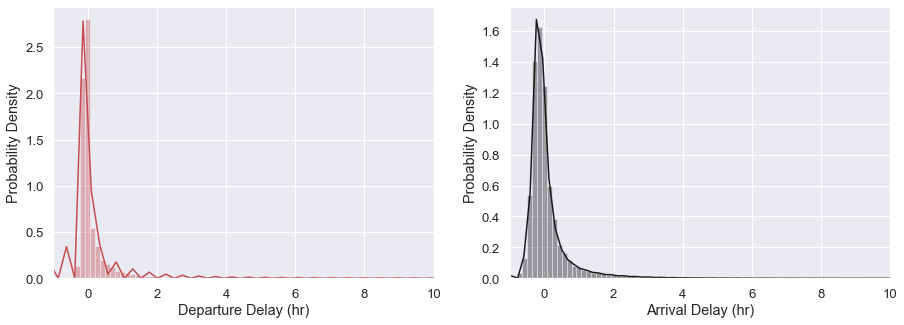

In [132]:
sns.set(font_scale=1.2)
fig, axs = pp.subplots(nrows=1, ncols=2, figsize=(15, 5))
data = flights.DepDelay.astype('timedelta64[m]') / 60
_ = sns.distplot(flights.DepDelay.astype('timedelta64[m]') / 60, bins=np.linspace(-2, 5, 50)-.5, ax=axs[0], color='r')
_ = axs[0].set_xlim([-1, 10])
_ = axs[0].set_xlabel('Departure Delay (hr)')
_ = axs[0].set_ylabel('Probability Density')
_ = sns.distplot(flights.ArrDelay.astype('timedelta64[m]') / 60, bins=np.linspace(-2, 5, 50)-.5, ax=axs[1], color='k')
_ = axs[1].set_xlim([-1, 10])
_ = axs[1].set_xlabel('Arrival Delay (hr)')
_ = axs[1].set_ylabel('Probability Density')

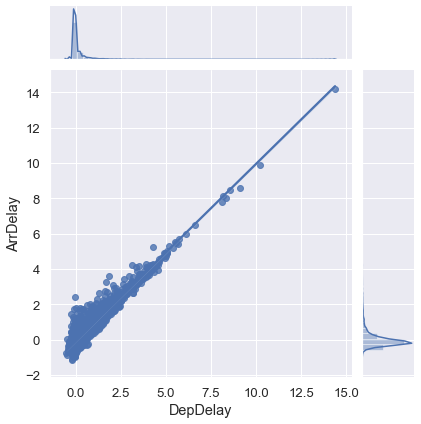

In [160]:
data = flights.sample(10000)
data['DepDelay'] = data['DepDelay'].astype('timedelta64[m]')/60
data['ArrDelay'] = data['ArrDelay'].astype('timedelta64[m]')/60
_ = sns.jointplot(x='DepDelay', y='ArrDelay', data=data, kind='reg')

                            OLS Regression Results                            
Dep. Variable:               ArrDelay   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 7.796e+04
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:45:57   Log-Likelihood:                 699.43
No. Observations:                9848   AIC:                            -1395.
Df Residuals:                    9846   BIC:                            -1380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0816      0.002    -34.865      0.0

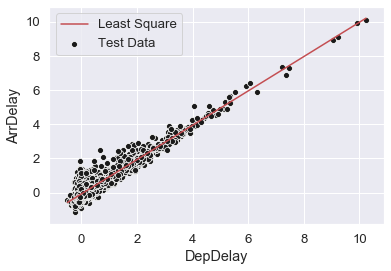

In [161]:
mod = smf.ols(formula='ArrDelay ~ 1 + DepDelay', data=data)
res = mod.fit()
print(res.summary())

new_data = flights.sample(10000) # new data
testArrDel = res.predict(new_data.DepDelay.astype('timedelta64[m]')/60)
_ = sns.lineplot(x=new_data.DepDelay.astype('timedelta64[m]')/60, y=testArrDel, color='r', label='Least Square')
_ = sns.scatterplot(x=new_data.DepDelay.astype('timedelta64[m]')/60, y=new_data.ArrDelay.astype('timedelta64[m]')/60, color='k', label='Test Data')

In [164]:
np.corrcoef(flights.Temp_O, flights.WindSp_O)

array([[ 1.       , -0.0201316],
       [-0.0201316,  1.       ]])

In [165]:
flights.iloc[:, 30:]

,TimeZoneDiff,Temp_O,DewPoint_O,RelHum_O,HeatInd_O,Dir_O,WindSp_O,Visib_O,Temp_D,DewPoint_D,RelHum_D,HeatInd_D,Dir_D,WindSp_D,Visib_D
0,03:00:00,57.000000,48.000000,71.809998,57.000000,200.0,3.45,8.0,25.000000,-6.000000,24.889999,16.250000,20.0,8.05,10.0
1,02:00:00,57.000000,48.000000,71.809998,57.000000,200.0,3.45,8.0,-11.000000,-17.000000,73.940002,-29.950001,300.0,10.35,10.0
2,02:00:00,26.100000,19.000000,74.160004,16.180000,350.0,10.35,10.0,8.100000,3.900000,82.580002,-4.350000,150.0,8.05,8.0
3,01:00:00,26.100000,19.000000,74.160004,16.180000,350.0,10.35,10.0,46.900002,12.000000,24.030001,44.090000,220.0,5.75,10.0
4,02:00:00,37.900002,30.900000,75.639999,29.129999,10.0,14.95,10.0,37.900002,28.900000,69.730003,29.920000,20.0,12.65,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7198899,01:00:00,36.000000,32.000000,85.230003,33.259998,60.0,3.45,10.0,78.099998,69.099998,73.879997,80.290001,90.0,13.80,10.0
7198900,01:00:00,75.199997,68.000000,78.339996,75.199997,100.0,11.50,10.0,78.099998,69.099998,73.879997,80.290001,90.0,13.80,10.0
7198901,03:00:00,53.099998,19.000000,25.879999,53.099998,90.0,4.60,10.0,37.000000,28.000000,69.629997,30.870001,210.0,8.05,10.0
7198904,02:00:00,28.400000,28.400000,100.000000,24.570000,330.0,3.45,0.5,36.000000,32.000000,85.230003,33.259998,60.0,3.45,10.0
